# LibPGM Benchmarking Runtime

Structure learning and CPD estimation algorithms have quite different complexity, this notebook contains routines to generate arbitrary BNs of varying num nodes and node complexity and then perform estimation benchmarking routines on them ...

In [75]:
# Imports
import random,json,copy,pprint,itertools,time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pyximport
pyximport.install(pyimport = True)
from libpgm.graphskeleton import GraphSkeleton
from libpgm.nodedata import NodeData
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner


In [67]:

def is_parent(n,pn,edges):
    n_edges = filter(lambda x: x[0] == n, edges)
    for e in n_edges:
        if e[1] == pn:
            return True
        else:
            if is_parent(e[1],pn,edges):
                return True
    return False

def generate_random_dag(nodes=10):
    nodes = map(lambda x: chr(x), range(65,65+nodes))
    edges = []
    for n in nodes:
        nl = copy.copy(nodes)
        random.shuffle(nl)
        for pn in nl:
            if pn==n:
                continue
            if is_parent(pn,n,edges):
                continue
#            print "new parent edge (%s,%s)"%(n,pn)
            edges.append( [n,pn] )
            break
#        print n
    return nodes,edges


# Plot the learned BN graph
def plot_digraph(nodes,edges):
    
    # Set up the graph 
    G = nx.DiGraph()
    red_edges = edges
    G.add_edges_from(edges)
    labels = dict(zip(nodes,nodes))

    # Plots ...
    plt.figure()
    plt.axis('off')
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color='g')
    nx.draw_networkx_labels(G,pos,labels,font_size=16)


def create_discrete_rvs(nodes, mincard=2, maxcard=30):
    word_file = "/usr/share/dict/words"
    words = open(word_file).read().splitlines()
    nodevals = {}
    for n in nodes:
        ncard = np.random.randint(mincard,maxcard)
        nodevals[n] = random.sample(words, ncard)
    return nodevals
        

In [68]:


def generate_random_bn(num_nodes=4, min_card=2, max_card=4):
    V,E = generate_random_dag(num_nodes)
    NV = create_discrete_rvs(V, min_card, max_card)

    graph = {
        "V": V,
        "E": E,
        "Vdata":{}
    }

    for n in V:
        parents = map(lambda x: x[1], filter(lambda x: x[0]==n, E))
        children = map(lambda x: x[0], filter(lambda x: x[1]==n, E))
        parentvals = map(lambda x: NV[x], parents)
        possible_conditions = list(itertools.product(*parentvals))
        noutcomes = len(NV[n])
        if(len(parents)==0):
            parents = None
        if(len(children)==0):
            children = None
        cprob = {}
        if len(possible_conditions) > 1:
            for condition_vals in possible_conditions:
                p = np.random.exponential(size=noutcomes)
                k = str(list(condition_vals))
                cprob[k] = list(p / np.sum(p))
        else:
            p = np.random.exponential(size=noutcomes)
            k = str(list(condition_vals))
            cprob = list(p / np.sum(p))

        nv = {
#        "ord":len(NV[n]),
            "numoutcomes":noutcomes,
            "vals":NV[n],
            "parents":parents,
            "children":children,
            "cprob":cprob
        }
        graph["Vdata"][n] = nv

        
    return graph

def plot_bn(graph):
    plot_digraph(graph['V'],graph['E'])


In [69]:

# Generate a libpgm BN from our model
def gen_discrete_bn(graph):
    skel = GraphSkeleton()
    skel.V = graph['V']
    skel.E = map(lambda x: [x[1],x[0]], graph['E'])
    skel.toporder()
    for i,n in enumerate(skel.V):
        graph["Vdata"][n]["ord"] = i            
    nd = NodeData()
    nd.Vdata = graph['Vdata']
    bn = DiscreteBayesianNetwork(skel, nd)
    return bn

def print_node_cardinalities(graph):
    print "Node Cardinalities..."
    for n in graph["V"]:
        print n,len(graph["Vdata"][n]['vals'])
        

A 19
B 28
C 20
D 23
E 24
F 2
G 4
H 5
I 19
J 4
K 26
L 24


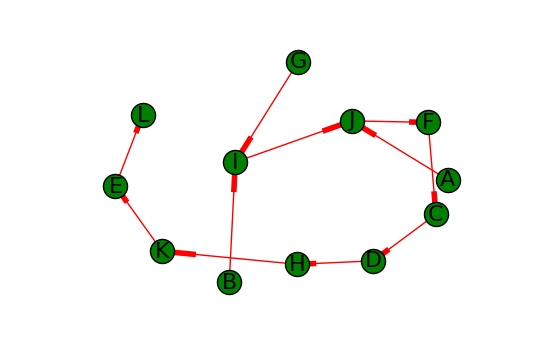

In [70]:
# Generate and Sample from random BN
n_nodes = 12
card_min = 2
card_max = 30

g = generate_random_bn(n_nodes,card_min,card_max)
plot_bn(g)
bn = gen_discrete_bn(g)
samples = bn.randomsample(1024*256, evidence={})
print_node_cardinalities(g)

In [71]:


s1 = [16,32,64,128,256,512,1024]
s2 = [16,32,64,128,256,512,1024,2048,1024*4,1024*8,1024*16,1024*32,1024*64,1024*128,1024*256]

learner = PGMLearner()

# Time the structure learning ...
structure_runtimes = []
cpd_runtimes = []
for s in s1:
    t1 = time.time()
    skel = learner.discrete_constraint_estimatestruct(samples[0:s])
    t2 = time.time()    
    structure_runtimes.append( t2-t1 )
    print "structure", s, t2-t1
    
for s in s2:
    t1 = time.time()
    bn = learner.discrete_mle_estimateparams(skel, samples[0:s])
    t2 = time.time()    
    cpd_runtimes.append( t2-t1 )
    print "cpd est", s, t2-t1
    

structure 16 1.29411411285
structure 32 3.24537181854
structure 64 7.20518398285
structure 128 9.41074705124
structure 256 13.6568279266
structure 512 28.7504279613
structure 1024 29.3432650566
cpd est 16 0.00615692138672
cpd est 32 0.0162601470947
cpd est 64 0.0244219303131
cpd est 128 0.0398850440979
cpd est 256 0.261507987976
cpd est 512 0.0744690895081
cpd est 1024 0.0894310474396
cpd est 2048 0.153006076813
cpd est 4096 0.341696977615
cpd est 8192 0.429939985275
cpd est 16384 0.768908023834
cpd est 32768 2.06272006035
cpd est 65536 3.1479640007
cpd est 131072 5.56964898109
cpd est 262144 14.6848320961


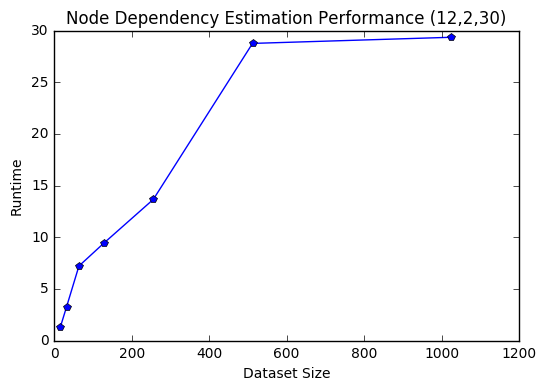

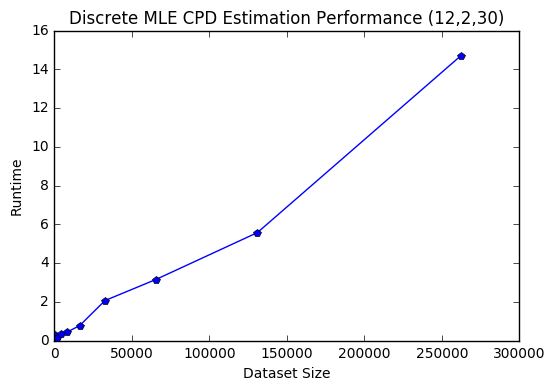

In [72]:
plt.figure()
plt.plot(s1, structure_runtimes,'p-')
plt.xlabel("Dataset Size")
plt.ylabel("Runtime")
plt.title("Node Dependency Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))
plt.figure()
plt.plot(s2, cpd_runtimes,'p-')
plt.xlabel("Dataset Size")
plt.ylabel("Runtime")
plt.title("Discrete MLE CPD Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))

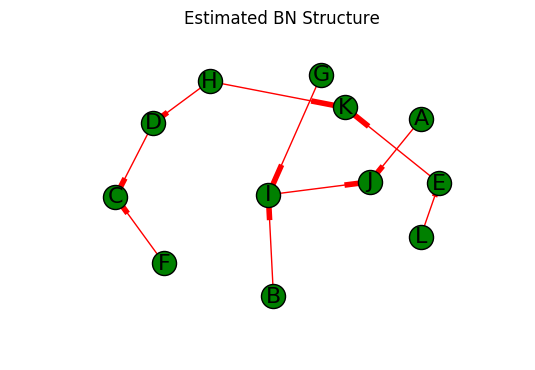

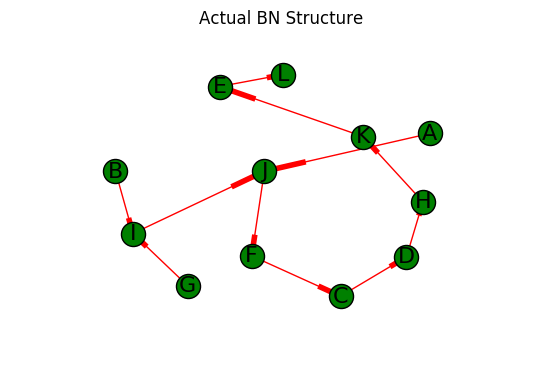

In [74]:
# Plot the learned BN graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Set up the graph 
G = nx.DiGraph()
red_edges = bn.E
G.add_edges_from(bn.E)
usednodes = []
for edge in bn.E:
    usednodes.append(edge[0])
    usednodes.append(edge[1])
usednodes = list(set(usednodes))
values = usednodes
labels = dict(zip(values,values))

# Plots ...
plt.figure()
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_nodes(G,pos,nodelist=values,node_color='g')
nx.draw_networkx_labels(G,pos,labels,font_size=16)
plt.title("Estimated BN Structure")

plot_bn(g)
plt.title("Actual BN Structure")

In [77]:
print "Ground Truth... "
pprint.pprint(g)

{'E': [['A', 'J'],
       ['B', 'I'],
       ['C', 'D'],
       ['D', 'H'],
       ['E', 'L'],
       ['F', 'C'],
       ['G', 'I'],
       ['H', 'K'],
       ['I', 'J'],
       ['J', 'F'],
       ['K', 'E']],
 'V': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'],
 'Vdata': {'A': {'children': None,
                 'cprob': {'["chimera\'s"]': [0.059498087522156511,
                                              0.0074263255375007628,
                                              0.010245412334182233,
                                              0.014370030431084741,
                                              0.10103962384116279,
                                              0.08136929180390215,
                                              0.084280887924143844,
                                              0.051960074890176032,
                                              0.047580997258462231,
                                              0.057127530913513573,
        

In [80]:
print "Estimated Model"
pprint.pprint(bn.Vdata)

Estimated Model
{'A': {'children': ['J'],
       'cprob': [0.046047210693359375,
                 0.030788421630859375,
                 0.10152816772460938,
                 0.053226470947265625,
                 0.07786941528320312,
                 0.06085968017578125,
                 0.031291961669921875,
                 0.0843505859375,
                 0.059429168701171875,
                 0.059711456298828125,
                 0.0724945068359375,
                 0.039569854736328125,
                 0.024242401123046875,
                 0.026859283447265625,
                 0.040435791015625,
                 0.0462188720703125,
                 0.04970550537109375,
                 0.057788848876953125,
                 0.0375823974609375],
       'numoutcomes': 19,
       'parents': [],
       'vals': ['indemnifying',
                "liveliness's",
                'honey',
                'Vern',
                "Yamagata's",
                'drag',
                "br